<center>
<img src="./images/ods_stickers.jpg" />
    
# Introducción al Machine Learning 2020

Basado en material de Pattern Classsification Duda, Hart, Stork. Traducido y editado al español por [Ana Georgina Flesia](https://www.linkedin.com/in/georginaflesia/). Este material esta sujeto a los términos y condiciones de la licencia  [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Se permite el uso irrestricto para todo propósito no comercial.Copyright (c) 2019 [Georgina Flesia](georgina.flesia@unc.edu.ar)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#sklearn imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import (SGDClassifier,
                                  Perceptron,
                                  PassiveAggressiveClassifier,
                                  LogisticRegression)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix as pl_cm
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable

# IntML2020 - Clasificación sobre Winsconsin breast cancer dataset - SVM

# Ejercicio 1:

* a) Revise  la seccion 5.8.5 del libro de Duda et al sobre metodos de aproximacion estocastica y el algoritmo LMS para tener una idea general de los algoritmos de Stochastic Gradient Descent que lideran la resolucion de linear SVM y Neural Networks.


* b)Sobre el grupo de datos sobre cancer de mama, aplique Linear SVM usando  Stochastic gradient descent, Perceptron y estrategias Passive Agressive,   separando en 80% train y 20% test cinco veces. Arme las matrices de confusion y curvas ROC y discuta los resultados haciendo énfasis en la diferencia entre los solvers. Use el siguiente codigo para ayudarse. 

Attribute Information:

ID number 2) Diagnosis (M = malignant, B = benign) 3–32)
Ten real-valued features are computed for each cell nucleus:

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter² / area — 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension (“coastline approximation” — 1)

The mean, standard error and “worst” or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

In [2]:
#importing the dataset 
df = pd.read_csv('data_breast_cancer.csv')
dataset = df.drop(['Unnamed: 32'], axis=1)
X = dataset.iloc[:, 2:32].values
Y = dataset.iloc[:, 1].values

dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
dataframe = pd.DataFrame(Y)

#Encoding categorical data values 
labelencoder_Y = LabelEncoder()
Y1 = labelencoder_Y.fit_transform(Y)

In [4]:
#Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(X)

In [5]:
#Load classifiers 
classifiers = [
    # SGDClassifier (soft-margin) linear Support Vector Machine
    ("SGD", SGDClassifier(max_iter=100, tol=1e-3)),
    # SGDClassifier (soft-margin) linear Support Vector Machine with averaged weights
    ("ASGD", SGDClassifier(average=True, max_iter=1000, tol=1e-3)),
    ("Perceptron", Perceptron(tol=1e-3)),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge',
                                                         C=1.0, tol=1e-4)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',
                                                          C=1.0, tol=1e-4)),
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0],
                               multi_class='auto'))
]

training SGD
training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG


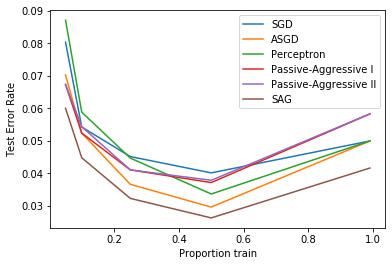

In [6]:
# Splitting the dataset into the training set and test set to study the solvers 
heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20
xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
                train_test_split(X, Y1, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate");

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



SGDClassifier(max_iter=100)
Normalized confusion matrix
[[0.94 0.06]
 [0.06 0.94]]


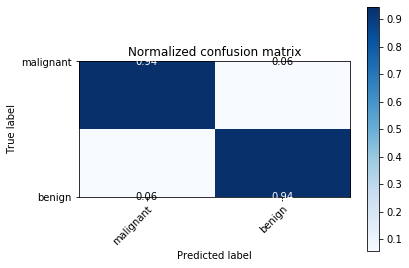

SGDClassifier(average=True)
Normalized confusion matrix
[[0.93 0.07]
 [0.06 0.94]]


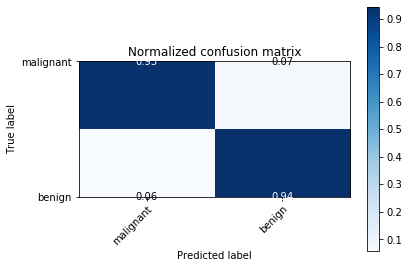

Perceptron()
Normalized confusion matrix
[[0.97 0.03]
 [0.06 0.94]]


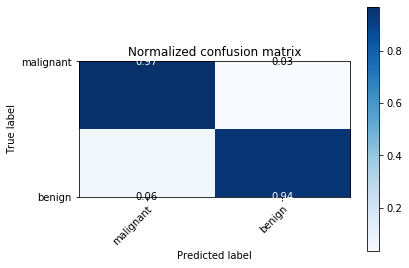

PassiveAggressiveClassifier(tol=0.0001)
Normalized confusion matrix
[[0.98 0.02]
 [0.06 0.94]]


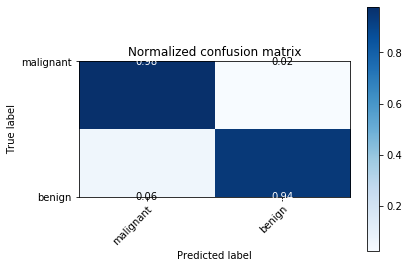

PassiveAggressiveClassifier(loss='squared_hinge', tol=0.0001)
Normalized confusion matrix
[[0.94 0.06]
 [0.06 0.94]]


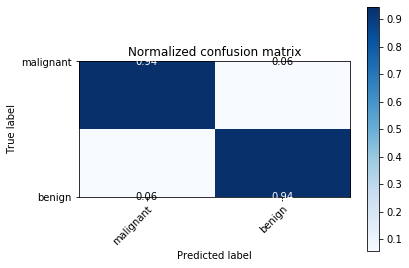

LogisticRegression(C=17.57469244288225, solver='sag', tol=0.1)
Normalized confusion matrix
[[0.98 0.02]
 [0.06 0.94]]


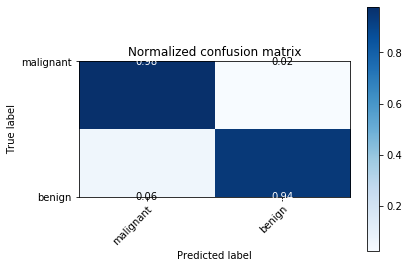

In [8]:
y_labels = np.array(['malignant', 'benign'])

# Splitting the dataset into the Training set and Test set to return ROC and confusion matrices
X_train, X_test, y_train, y_test = train_test_split(X, Y1, 
                                                    test_size = 0.25, random_state = 0)

#classes = Y_labels[unique_labels(Y_test, Y_pred)]

# iterate over classifiers
lst=[]
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    lst.append(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    np.set_printoptions(precision=2)
    print(clf)
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=y_labels, 
                          normalize=True,title='Normalized confusion matrix')
    # Plot non-normalized confusion matrix
    #plot_confusion_matrix(Y_test, Y_pred, classes=Y,title='Confusion matrix, without normalization')
    plt.show()

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,title='Normalized confusion matrix')


In [9]:
#errors
print(lst)

[0.9440559440559441, 0.9370629370629371, 0.958041958041958, 0.965034965034965, 0.9440559440559441, 0.965034965034965]


## Respuesta

<span style="color:green"> RESPUESTA (a)</span>

En los clasificadores lineales queremos encontrar una línea (o hiperplano) que minimize los alejamientos verticales. O en otras palabras, queremos definir el mejor ajuste lineal que minimize la suma de errores cuadrados $\textbf{SSE}$ o el error cuadrático medio $\textbf{MSE}$ entre la variable target (y) y la etiqueta predicha sobre todas las muestras $i$ en el dataset de tamaño $n$. Es decir:

$$\textbf{SSE} = \sum_i (target^{(i)} - salida^{(i)})$$

$$\textbf{MSE} = \dfrac{1}{n}\textbf{SSE}$$

Esto lo podemos resolver analíticamente o usando algoritmos de optimización (Gradient Descent, Stochastic Gradient Descent, Newton's Method, Simplex Method, etc.)

Para entender Stochastic Gradient Descent (SDG) veamos primero Gradient Descent (GD).

**Gradient Descent (GD)**

Usando este algoritmo, los pesos $(w_i)$ son actualizados incrementalmente despues de cada iteración sobre los datos de entrenamiento. La función costo, $J(.)$, de la suma de errores cuadráticos (SSE) puede ser escrita como: 

La magnitud y dirección de la actualización de pesos se calcula dando un paso en la dirección opuesta del gradiente de costo:

$$\Delta w_j = -\eta\; \dfrac{\partial J}{\partial w_j}$$


donde $\eta$ es la tasa de aprendizaje. Los pesos se actualizan después de cada iteración mediante la siguiente regla de actualización:

$$\textbf{w} := \textbf{w} + \Delta \textbf{w}$$


donde $\Delta \textbf{w}$ es un vector que contiene las actualizaciones de peso de cada coeficiente de peso w, que se calculan de la siguiente manera:

$$\Delta w_j = -\eta\; \dfrac{\partial J}{\partial w_j} = -\eta\; \sum_i (target^{(i)} - salida^{(i)}) (-x_j^{(i)}) = \eta\; \sum_i (target^{(i)} - salida^{(i)})x_j^{(i)}$$

Esencialmente, podemos imaginar la optimización de GD como un excursionista (el coeficiente de peso) que quiere descender una montaña (función de costo) en un valle (costo mínimo), y cada paso está determinado por la inclinación de la pendiente (gradiente) y el longitud de la pierna del excursionista (tasa de aprendizaje). 

**STOCHASTIC GRADIENT DESCENT (SGD)**

En la optimización de GD, calculamos el gradiente de costos en función del dataset de entrenamiento completo; Por lo tanto, a veces también lo llamamos *batch GD*. En el caso de conjuntos de datos muy grandes, el uso de GD puede ser bastante costoso ya que sólo estamos dando un solo paso con una iteración sobre el conjunto de entrenamiento; por lo tanto, cuanto más grande sea el conjunto de entrenamiento, más lento será nuestro algoritmo para actualizar los pesos y más tiempo puede llevar hasta que converja con el costo mínimo global (teniendo en cuenta que la función de costo SSE es convexa).

En Descenso de gradiente estocástico (SGD; a veces también denominado GD iterativo u online), actualizamos los pesos despues de cada muestra de entrenamiento:

$$para\;uno\;o\;mas\;iteraciones\; o \; hasta \; que \; el \; costo \; mínimo \; sea \; alcanzado:$$
    $$para\;  cada\;  muestra \; de \; entrenamiento \; i:$$
    $$para\;  cada\;  peso \; j:$$
        $$w_j := {w} + \Delta w_j,\; donde\;\Delta w_j = \eta\;(target^{(i)} - salida^{(i)})x_j^{(i)}$$


Aquí, el término "estocástico" proviene del hecho de que el gradiente basado en una sola muestra de entrenamiento es una "aproximación estocástica" del gradiente de costo "verdadero". Debido a su naturaleza estocástica, el camino hacia el costo mínimo global no es "directo" como en GD, pero puede ir en "zig-zag" si estamos visualizando la superficie de costo en un espacio 2D. Sin embargo, se ha demostrado que SGD casi seguramente converge al mínimo de costo global si la función de costo es convexa (o pseudoconvexa).Además, existen diferentes trucos para mejorar el aprendizaje basado en GD, por ejemplo:

- Una tasa de aprendizaje adaptativo $\eta$ al elegir una constante de disminución $d$ que reduce la tasa de aprendizaje con el tiempo:

$$\eta(t+1) := \eta(t)/(1 + t \times d)$$

- Momentum learning agregando un factor de gradiente antes de la actualización de peso para actualizaciones más rápidas:

$$\Delta w_{t+1} := \eta \nabla J(w_{t+1}) + \alpha \Delta w_t$$

<span style="color:green"> RESPUESTA (b)</span>

In [10]:
my_classifiers = [
    # SGDClassifier (soft-margin) linear Support Vector Machine
    ("SGD", SGDClassifier(max_iter=100, tol=1e-3)),
    # SGDClassifier (soft-margin) linear Support Vector Machine with averaged weights
    ("ASGD", SGDClassifier(average=True, max_iter=1000, tol=1e-3)),
    ("Perceptron", Perceptron(tol=1e-3)),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge',
                                                         C=1.0, tol=1e-4)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',
                                                          C=1.0, tol=1e-4)),
]

In [11]:
mean_errors = []

# iterate over my_classifiers
for name, clf in my_classifiers:
    print("* Training: %s" % name)
    rng = np.random.RandomState(42)
    splits_errors = []
    # for each classifier separate 5 times
    # in train and test set (80/20)
    for r in range(5):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, Y1, test_size=0.2, random_state=rng)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # get the error of this split
        splits_errors.append(1 - np.mean(y_pred == y_test))
    # quite the mean error of the five splits.
    mean_errors.append(np.mean(splits_errors))
    print('---> The mean error for this classifier was: %2.5f' % np.mean(splits_errors))
    print()

* Training: SGD
---> The mean error for this classifier was: 0.02632

* Training: ASGD
---> The mean error for this classifier was: 0.01930

* Training: Perceptron
---> The mean error for this classifier was: 0.03860

* Training: Passive-Aggressive I
---> The mean error for this classifier was: 0.02105

* Training: Passive-Aggressive II
---> The mean error for this classifier was: 0.02632



Los errores promedios son menores se encuentran en el mismo rango y son menores a 0.1.

In [12]:
# Splitting the dataset into the training set and test set 
# to return ROC and confusion matrices
X_train, X_test, y_train, y_test = train_test_split(X, Y1, 
                                                    test_size=0.2,
                                                    random_state=0)

('SGD', SGDClassifier(max_iter=100))
('ASGD', SGDClassifier(average=True))
('Perceptron', Perceptron())
('Passive-Aggressive I', PassiveAggressiveClassifier(tol=0.0001))
('Passive-Aggressive II', PassiveAggressiveClassifier(loss='squared_hinge', tol=0.0001))


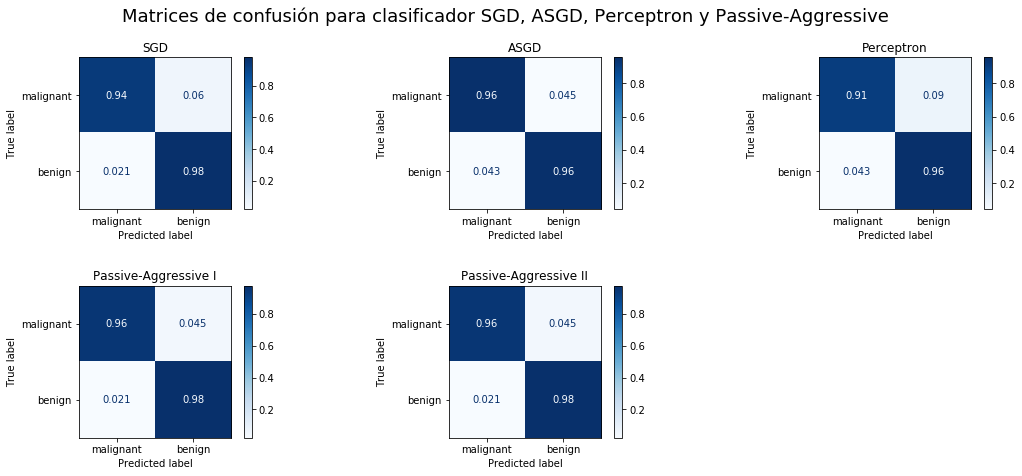

In [13]:
# Create a figure for the confusion matrices
fig_cm = plt.figure(figsize=(18, 7))


# iterate over the classifier
for idx, clf in enumerate(my_classifiers):
    ax = fig_cm.add_subplot(2, 3, idx+1)
    ax.set_title(str(clf[0]))
    clf[1].fit(X_train, y_train)
    print(clf)
    pl_cm(clf[1], X_test, y_test, 
          display_labels=y_labels,
          cmap=plt.cm.Blues,
          ax=ax, normalize='true')
    
fig_cm.subplots_adjust(hspace=0.5, wspace=0.4)
fig_cm.suptitle('Matrices de confusión para clasificador SGD, ASGD, Perceptron y Passive-Aggressive', size=18);

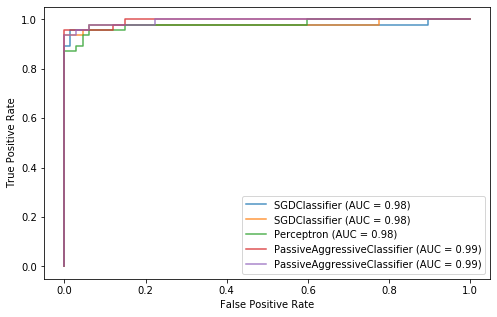

In [14]:
from sklearn.metrics import plot_roc_curve

# Create a figure for the confusion matrices
fig_roc, ax = plt.subplots(1, 1, figsize=(8, 5))

for clf in my_classifiers:
    clf[1].fit(X_train, y_train)
    ax = plt.gca()
    plot_roc_curve(clf[1], X_test, y_test, ax=ax, alpha=0.8)

La curva ROC muestra que todos los clasificador son muy buenos y los solvers no hacen diferencia en la performace de clasificación.

# Ejercicio 2: 

a. Estudie el espacio de parámetros de los kernel SVM, usando RBF, sigmoid y polinomial kernels con los datos de cancer de mama. Use el siguiente codigo como ejemplo (corresponde a RGF SVM).

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


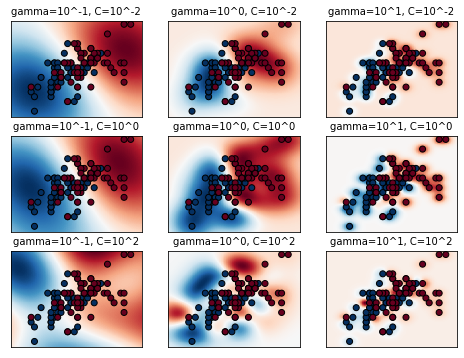

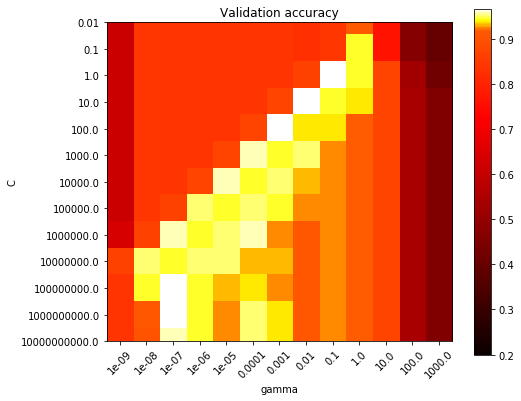

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# #############################################################################
# Load and prepare data set
#
# dataset for grid search

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X_iris[:, :2]
X_2d = X_2d[y_iris > 0]
y_2d = y_iris[y_iris > 0]
y_2d -= 1

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)
X_2d = scaler.fit_transform(X_2d)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_iris, y_iris)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# #############################################################################
# Visualization
#
# draw visualization of parameter effects

fig = plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    ax = fig.add_subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    ax.set_title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    ax.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

## Respuesta 

<span style="color:green"> RESPUESTA (a) </span>

In [16]:
# Dataset for decision function visualization: we only keep the first two
# features in X (cancer dataset)
X_2d_cancer = X[:, :2]

# Then scale the 2d features
X_2d_cancer = scaler.fit_transform(X_2d_cancer)

In [17]:
def generate_grid(kernel):
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    param_grid = dict(gamma=gamma_range, C=C_range, kernel=[kernel])
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
    grid.fit(X, Y1)
    print("The best parameters are %s with a score of %0.2f"
          % (grid.best_params_, grid.best_score_))
    return grid

def plot_decision_regions_svc(kernel):
    C_2d_range = [1e-2, 1, 1e2]
    gamma_2d_range = [1e-1, 1, 1e1]
    classifiers = []
    for C in C_2d_range:
        for gamma in gamma_2d_range:
            clf = SVC(C=C, gamma=gamma, kernel=kernel)
            clf.fit(X_2d_cancer, Y1)
            classifiers.append((C, gamma, clf))
        
    fig = plt.figure(figsize=(10, 8))
    xx, yy = np.meshgrid(np.linspace(-3, 5, 200), np.linspace(-3, 5, 200))
    for (k, (C, gamma, clf)) in enumerate(classifiers):
        # evaluate decision function in a grid
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # visualize decision function for these parameters
        plt.subplot(len(C_2d_range)+1, len(gamma_2d_range), k + 1)
        plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
                  size='medium')

        # visualize parameter's effect on decision function
        plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
        plt.scatter(X_2d_cancer[:, 0], X_2d_cancer[:, 1], c=Y1, cmap=plt.cm.RdBu_r,
                    edgecolors='k')
        plt.xticks(())
        plt.yticks(())
        plt.axis('tight')
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    fig.tight_layout()
    

def plot_accuracy(grid, kernel, ax):
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
    im = ax.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
                   norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_xticks(np.arange(len(gamma_range)))
    ax.set_yticks(np.arange(len(C_range)))
    ax.set_xticklabels(gamma_range, rotation=45)
    ax.set_yticklabels(C_range)
    ax.set_title('Validation accuracy - ' + kernel)

The best parameters are {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'} with a score of 0.98
The best parameters are {'C': 1.0, 'gamma': 0.1, 'kernel': 'poly'} with a score of 0.96
The best parameters are {'C': 100.0, 'gamma': 0.001, 'kernel': 'sigmoid'} with a score of 0.97


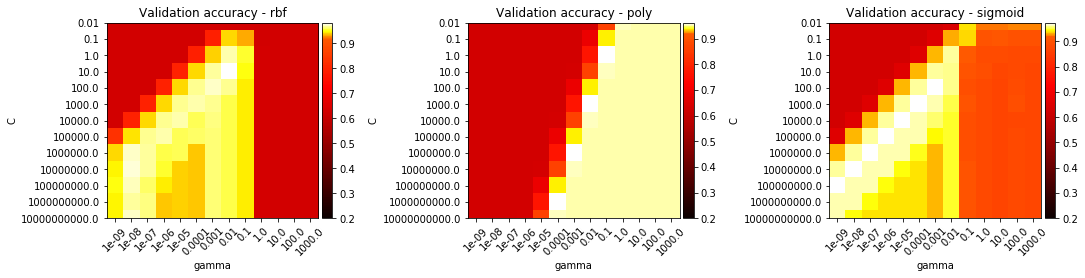

In [18]:
kernels = ['rbf', 'poly', 'sigmoid']

fig, axes = plt.subplots(1, 3, figsize=(17, 8))
for idx, k in enumerate(kernels):
    grid = generate_grid(k)
    plot_accuracy(grid, k, axes[idx])
fig.subplots_adjust(wspace=0.6)

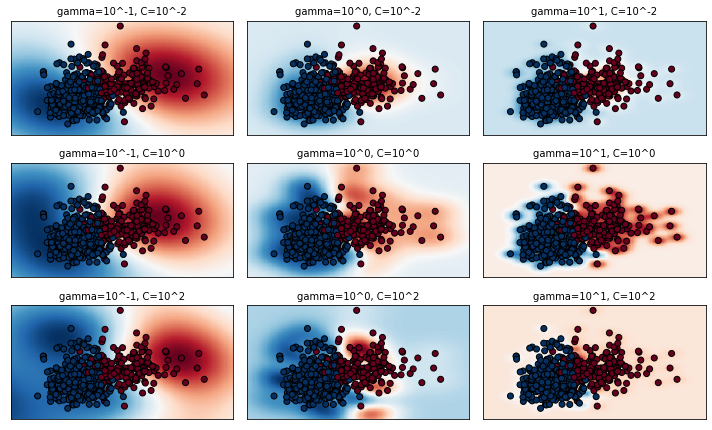

In [19]:
plot_decision_regions_svc('rbf')

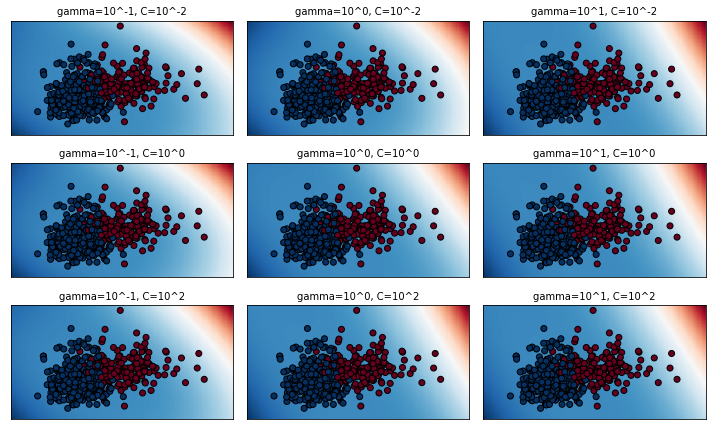

In [20]:
plot_decision_regions_svc('poly')

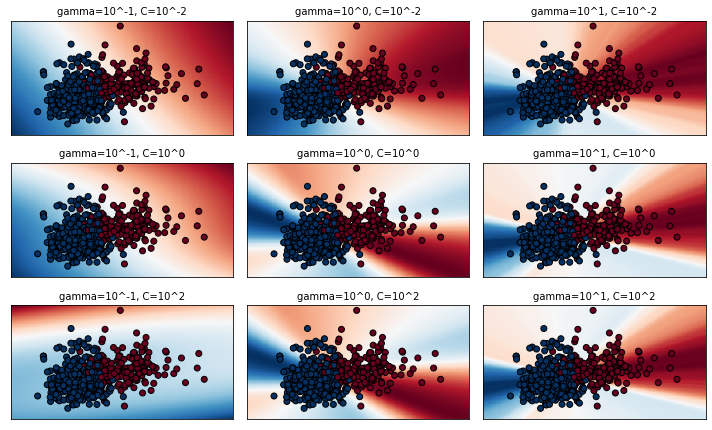

In [21]:
plot_decision_regions_svc('sigmoid')

# Ejercicio 3: 

Compare diferentes SVM sobre los datos de cancer de mama. Use los parámetros que estudio en el ejemplo anterior. 

## Respuesta

<span style="color:green"> RESPUESTA (a)</span>

Se observa como usar distintos kernel en SVM influye en los parámetros C y gamma que deben elegirse. Asimismo las regiones de decisión que resultan son completamente diferentes en todos los casos. Se observa que en plot del kernel 'poly', las regiones que quedan con esos parámetros son muy malas (los puntos rojos estan todos en la zona azul). Todos los kernel si tiene el parámetro adecuado pueden logar la mismo presición (0.98%). Sobre el validation accurracy, 'rbf' y 'sigmoid' tienen una apariencia similar, mientras que 'poly' separa en dos su espacio de parámetros (amarillo y rojo bien separados).

# Ejercicio 4: 

Compare diferentes  SVM sobre los datos de Digits. Estudie las estrategias para hacer una clasificacion con multiples clases y optimice el parametro $C$. Puede usar el codigo siguiente como guia.
En este código, se usa el default (cual es? ) para computar clasificacion multi clase. Cambie ese parametro para clasificacion one vs rest o multiclass, compute los scores, y diga cual estrategia es la mejor. 

In [22]:

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X_digits = digits.images.reshape((n_samples, -1))
y_digits = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model 